In [2]:
import sys
sys.path.insert(0, '/home/ldoyle/packages')
import h5py
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
import pysindy as ps
from lr_ed import localreg
from datetime import datetime
from scipy.fft import fft, fftfreq,rfft2
import scipy.signal as signal
from obspy.signal import filter as obsfilt

In [3]:
import glob
len(glob.glob("/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T233*"))

10

In [15]:
# path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"
# file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T232914Z.npy"
# file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231"+str(i)+"14Z.h5"

f = h5py.File('/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T233014Z.h5', 'r')
data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000


In [16]:
print('The spatial sampling interval is ',f['Acquisition'].attrs['SpatialSamplingInterval'],'m.')

The spatial sampling interval is  2.0419047 m.


In [5]:
sliced_data = data[7500:12500,:]

In [6]:
def gauss_lr(q):
    return localreg(np.arange(size_val).reshape(-1,1).astype(np.float64),q, degree=0, weight_matr=weight_matr,ind_list=incl_list)


In [12]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] =gauss_lr(i)

100%|██████████| 12000/12000 [25:16<00:00,  7.91it/s]


In [13]:
np.save('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T233014Z.npy', smoothed_dat)


## Gaussian

In [8]:
def kernel(t):
    res = (1/np.sqrt(2*np.pi))*np.exp(-0.5*t**2)
    return res

In [9]:
radius = 4
size_val = 5000#sliced_data.shape[0]
x0 = np.arange(size_val).reshape(-1,1)

weight_matr = np.zeros((size_val,size_val))
incl_list = []
for i, xi in enumerate(x0):
    weight_matr[i,:] = kernel(np.linalg.norm(x0-xi[None,:], axis=1)/radius)

    incl_list.append( np.where(np.abs(weight_matr[i,:])>1e-10)[0])

In [10]:
sliced_data.shape

(5000, 12000)

In [11]:
def gauss_lr(q):
    return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)

In [15]:
smoothed_dat = np.zeros(sliced_data.shape)
for i in tqdm(range(sliced_data.shape[1])):
    smoothed_dat[:,i] = gauss_lr(i)

 52%|█████▏    | 6221/12000 [21:05<11:33,  8.33it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 12000/12000 [32:38<00:00,  6.13it/s]


In [6]:
path = "/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/"

for i in np.arange(1):
    file = "South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T231"+str(i)+"14Z.h5"
    f = h5py.File(path+file, 'r')
    data = f['Acquisition']['Raw[0]']['RawData'][:, :].astype('int64')
#     timestamp = f['Acquisition']['Raw[0]']['RawDataTime'][:] / 1000000
    f.close()
    sliced_data = data[7500:12500,:]
    def gauss_lr(q):
        return localreg(np.arange(size_val),sliced_data[:,q], degree=0, weight_matr=weight_matr,ind_list=incl_list)
    smoothed_dat = np.zeros(sliced_data.shape)
    for i in tqdm(range(sliced_data.shape[1])):
        smoothed_dat[:,i] = gauss_lr(i)
    np.save('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_'+file[:-3]+'.npy', smoothed_dat)


100%|██████████| 12000/12000 [24:53<00:00,  8.04it/s]


In [16]:
np.save('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_'+file[:-3]+'.npy', smoothed_dat)
# smoothed_dat = np.load('/home/ldoyle/notebooks/rad_4_smooth_data/gaussian_smoothed_channels_7500_12500_'+file[:-3]+'.npy')

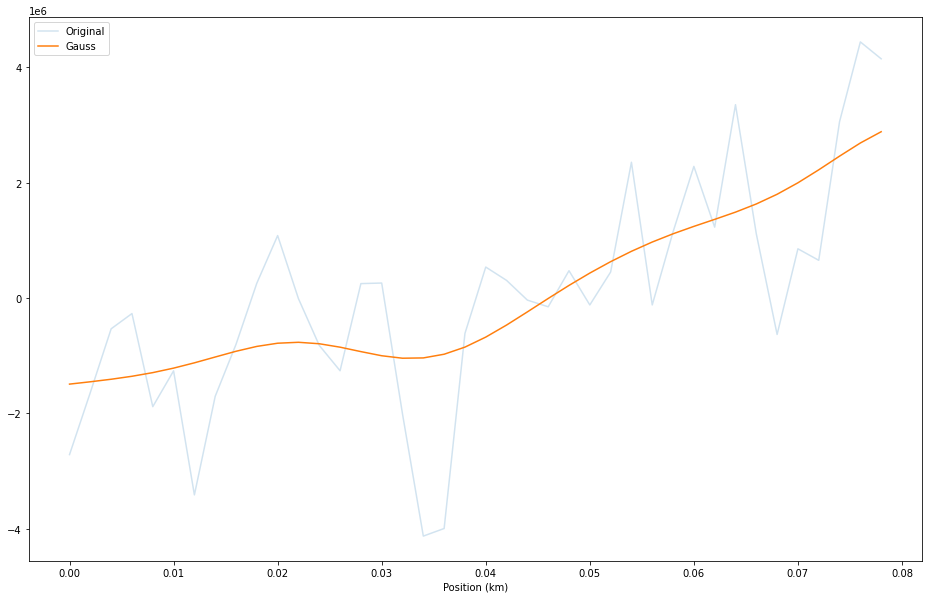

In [21]:
plt.figure(figsize=(16,10))
# plt.plot((2/1000)*np.arange(1000), lp_dat[740,:1000], label="BP Filt")
plt.plot((2/1000)*np.arange(40), data[7500:7540,740], label="Original", alpha=0.2)
plt.plot((2/1000)*np.arange(40), smoothed_dat[:40,740],label="Gauss")
plt.legend()
plt.xlabel("Position (km)")
plt.show()

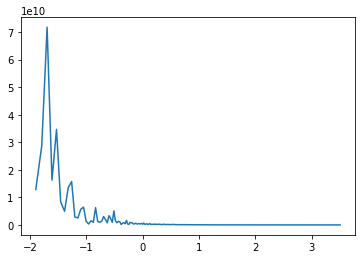

In [30]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000], 2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [31]:
np.amax(2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])

71730915097.91617

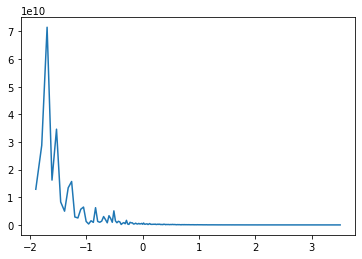

In [32]:
N=12000
yf1 = np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [33]:
np.amax(2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])

71491612707.09859

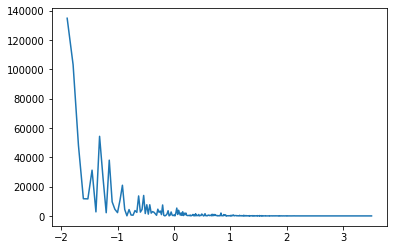

In [17]:
N=12000
yf1 = np.mean(fft(smoothed_dat),axis=0) - np.mean(fft(sliced_data),axis=0)
# yf3 = fft.rfft2(data[7500:12500,:])
xf = fftfreq(N, d=1/200)[1:N//2]
plt.figure()
plt.plot(np.log(xf)[8:-4000],2.0/N *(np.abs(yf1[1:N//2])**2)[8:-4000])
#plt.xlim(0,0.2)
plt.show()


In [18]:
np.amax(np.abs(yf1/np.mean(fft(smoothed_dat),axis=0)))

0.010996145937100073

## Bandpass